# Support vector machine, part 2: soft margins

## Introduction 

In the previous notebook we studied and implemented the Support vector machine algorithm for linearly separable datasets. In this notebook we study the case of non linearly separable data which can be reasonably separated by linear decision boundaries. 

## Non-linearly separable datasets

Suppose we have a dataset $S = \{(x^1,y^1),\dots,(x^m,y^m) \}\subset \mathbb{R}^n\times\{-1,1\}$ consisting of pairs (features,class). This time we do not assume the data can be separated by a hyperplane, and thus, solutions to the optimization problem posed in the previous notebook may not exist. We recall the optimization problem in its primal form:

$$
\begin{align*}
\min_{w,b}\ &\dfrac{1}{2}\|w\|^2\\
\text{subject to } &y^j(w\cdot x^j + b) > 1 \text{ for all } j. \\
\end{align*}
$$

Here $w$ represents the normal vector to the separating hyperplane, while $b$ represents a position vector for it. The condition $y^j(w\cdot x^j + b) > 1 $ can be thought as forcing each point $x^j$ to be in the correct side of the hyperplane. If this condition cannot be met for all points, we will relax it by requiring $y^j(w\cdot x^j + b) > 1 -\epsilon_j $ each $j$, where $\epsilon_j\geq 0$. This can be thought that we allow points to cross the hyperplane and be in the wrong side of it, up to a certain margin, controlled individually for each point by $\epsilon_i$. We want to allow the smallest margin of error as possible, so we penalize the size of the of the coefficients $\epsilon_i$. Thus, we reformulate the optimization problem as 

$$
\begin{align*}
\min_{w,b}\ &\dfrac{1}{2}\|w\|^2 + C\sum_{i=1}^m \epsilon_i \\
\text{subject to } &y^j(w\cdot x^j + b) > 1  - \epsilon_i ,\\
&\epsilon_i \geq 0\text{ for all } j.
\end{align*}
$$

Here $C$ is a constant that gauges the interaction between the two terms to optimize. It constitutes a hyperparameter of the model and can be optimized using cross-validation methods. The Lagrangian to minimize for the dual problem is given by

$$
\mathcal L (w,b,\alpha,\beta,\epsilon) = -(\dfrac{1}{2}\|w\|^2 + C\sum_{i=1}^m \epsilon_i  - \sum_{i=1}^m \alpha_i (y^i(w\cdot x^i + b) - (1 -\epsilon_i))  -\sum_{i=1}^m \beta_i \epsilon_i).
$$

The [KKT](https://en.wikipedia.org/wiki/Karush–Kuhn–Tucker_conditions) for this problem are then:

$$
\begin{align*}
\nabla_w \mathcal{L} =  -(w - \sum_{i=1}^m \alpha_i y^i x^i) &=   0, \\
\nabla_b \mathcal{L} =   -\sum_{i=1}^m \alpha_i y^i &=   0 , \\
\nabla_\epsilon \mathcal{L} = - (C-\alpha_i - \beta_i) &=0, \\
\alpha_i (y^i(w\cdot x^i + b) - (1-\epsilon_i) ) & = 0,\\
\beta_i \epsilon_i &=0 , \\
\alpha_i & \geq 0, \\
\beta_i & \geq 0, \\
\epsilon_i & \geq 0,
\end{align*}
$$

for all $i$. Substituting the gradient equations in the Lagrangian, we obtain a new optimization problem given by

$$
\begin{align*}
\min_{\alpha} \dfrac{1}{2} \sum_{i,j=1}^m \alpha_i \alpha_ j y^i  y^j x^i\cdot x^j -\sum_{i=1}^m \alpha_i 
\end{align*}
$$

subject to 

$$
\begin{align*}
\sum_{i=1}^m \alpha_i y^i &=  0 \\
C\geq \alpha_i & \geq 0. \\
\end{align*}
$$

If we solve this problem, we can recover $w$ from

$$
w = \sum_{i=1}^m \alpha_i y^i x^i
$$

and to recover $b$, we fix a support vector $x^s$ (that is, $0<\alpha_s < C$) and $\epsilon_s = 0$ (since $\beta_s\neq 0$) and from the condition $\alpha_i (y^i(w\cdot x^i + b) - (1-\epsilon_i) )  = 0$ it follows that 

$$
b = y_s^{-1} - w\cdot x^s.
$$

The predictions are then given by

$$
\widehat y = \mathrm{sign}(w\cdot x + b).
$$

We proceed to implement the algorithm.


## Implementation

In this section we implement the algorithm described above. We follow the same outline of the previous notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

We generate two classes of points which are not linearly separable. We fix a seed of random numbers so we always get the same dataset:

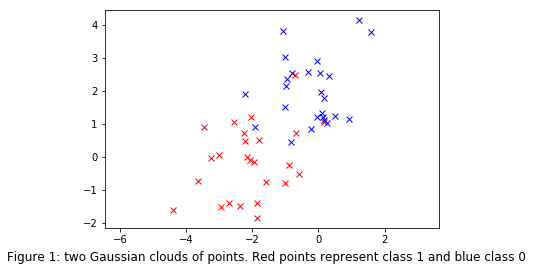

In [2]:
np.random.seed(6)
class_0 = 25 
class_1 = 25

x0 = np.random.multivariate_normal([-2, 0], [[1, .15],[.15, 1]], class_0)
x1 = np.random.multivariate_normal([0, 2], [[1, .25],[.25, 1]], class_1)

plt.plot(x0[:,0],x0[:,1],'x',color='red')
plt.plot(x1[:,0],x1[:,1],'x',color='blue')
plt.figtext(0.5, 0.01, 'Figure 1: two Gaussian clouds of points. Red points represent class 1 and blue class 0', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.axis('equal')
plt.show()

y0 = -np.ones(len(x0))
y1 = np.ones(len(x1))

X_train =  np.vstack((x0,x1))
y_train = np.append(y0,y1)

We compute the matrix containing the inner products of the points of the dataset.

In [3]:
def inner_prods(X_train):
    return np.dot(X_train,X_train.T)

With this, we can write the cost function as:

In [4]:
def cost(alpha): 
    return -(np.sum(alpha) - (1/2)*np.dot(np.multiply(alpha,y_train),
                                        np.dot(inner_prods(X_train),np.multiply(alpha,y_train))))

We define the constraint given by the KKT conditions. This is of the form $\sum_{i=1}^m \alpha_i y^i = 0$.

In [5]:
def cons1(alpha):
    return np.dot(alpha,y_train)

cons = ({'type': 'eq', 'fun': cons1})

We also set the conditions for the Lagrange multipliers: $C\geq\alpha_i \geq 0$. We set $C = 1000$ for the example:

In [6]:
C = 1000
bds = [(0,C) for _ in range(len(X_train))]

Now, we need an initial guess for the value of $\alpha_i$ for the optimizer:

In [7]:
alpha = np.random.random(len(X_train))

Finally, we optimize the cost function 

In [8]:
res = minimize(cost, alpha , bounds=bds, constraints=cons)

We recover the values of $\alpha_i$ that optimize the Lagrangian:

In [9]:
alpha = res.x

We will set to zero the values $\alpha_i$ which are smaller than $10^{-7}$:

In [10]:
alpha = alpha*(1*(alpha > 10**(-7)))

We can now construct the parameters $w,b$:

In [11]:
w = 0
for i in range(len(X_train)):
    w += y_train[i]*alpha[i]*X_train[i,:]

b = y_train[(alpha > 0) & (alpha < C)][0] - np.dot(w,X_train[(alpha > 0) & (alpha < C)][0])

With this, we can build the prediction function:

In [12]:
def predict(x,w,b):
    return np.sign(np.dot(x,w)+b)

Finally, we can plot the decision boundary given by the SVM as well as the regions predicted for each class. We can see how the separating hyperplane maximizes the margin to both classes.

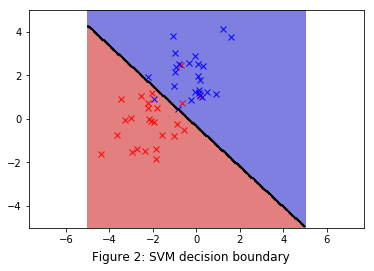

In [13]:
plt.plot(x0[:,0],x0[:,1],'x',color='red')
plt.plot(x1[:,0],x1[:,1],'x',color='blue')
plt.figtext(0.5, 0.01, 'Figure 2: SVM decision boundary', 
            wrap=True, horizontalalignment='center', fontsize=12)

x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
z = np.zeros(X.shape)
Z = np.array(z)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = predict(np.array([x[j],y[i]]).reshape(1,2),w,b)
plt.contourf(X, Y, Z, alpha=.5, cmap='jet_r')
C = plt.contour(X, Y, Z,  colors='black',zorder=4)
plt.axis('equal')
plt.show()

We can check the support vectors and plot them together with the separating hyperplane

In [14]:
sup_vect = X_train[alpha > 0]
sup_vect

array([[-0.70967236,  2.48106195],
       [-2.55221151,  1.0616012 ],
       [-0.66915023,  0.72634764],
       [-0.58912856, -0.52122884],
       [ 0.15695433,  1.0690201 ],
       [-1.79937151,  0.50534982],
       [-2.03140158,  1.21456088],
       [-0.90047109, -0.24801617],
       [-0.82341316,  0.4473006 ],
       [ 0.12726628,  1.19871734],
       [ 0.17361615,  1.12422702],
       [ 0.26801452,  1.0253296 ],
       [-1.0225964 ,  1.51861516],
       [-2.23271581,  1.90999537],
       [-0.2382763 ,  0.8559366 ],
       [-0.05097576,  1.22412656],
       [-1.93091128,  0.91924923]])

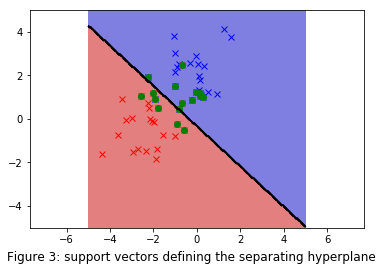

In [15]:
plt.plot(x0[:,0],x0[:,1],'x',color='red')
plt.plot(x1[:,0],x1[:,1],'x',color='blue')
plt.figtext(0.5, 0.01, 'Figure 3: support vectors defining the separating hyperplane', 
            wrap=True, horizontalalignment='center', fontsize=12)

x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, Z, alpha=.5, cmap='jet_r')
C = plt.contour(X, Y, Z,  colors='black',zorder=4)
plt.plot(sup_vect[:,0],sup_vect[:,1],'o',color='green')


plt.axis('equal')
plt.show()

## Final remarks

In this notebook we implemented the support vector machine for non-linearly separable datasets, using a linear decision boundary. This meant that points from different classes were allowed to cross the (soft) margin, up to a certain distance. In the next notebook we will implement SVM with non linear decision boundaries by making use of the kernel trick.